# Gridworld Bayesian RL
This notebook aims to setup a standard and a more advanced gridworld problem for implementing a Bayesian Inference RL approach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from matplotlib.patches import Rectangle, FancyArrow
from matplotlib.patches import Patch
from collections import defaultdict
import time

# PILCO file data
from PILCO import GridWorld, GPModel, RBFPolicy, _warm_start_policy, propagate_moments,compute_q, rollout_and_cost, optimize_policy, _bfs_distances, _action_toward_terminal, collect_data_random, collect_data_policy, fit_gp_models, evaluate_policy, visualize_policy   

In [2]:
def plot_gridworld(gridworld,start_cells,forbidden_cells,end_cells,gradient,actions,savepath):
    
    #ticks = np.arange(0,10,1)
    x_ticks = np.arange(gridworld.shape[1]) 
    y_ticks = np.arange(gridworld.shape[0]) 
    l = np.shape(gridworld)[0]

    if gradient:
        display_grid = gridworld
        cmap = 'viridis'
        vmin=np.min(gridworld)
        vmax=np.max(gridworld)
        #print(vmin,vmax)
    else:
        cmap = 'gray'
        vmin = 0
        vmax = 1
        display_grid = np.ones_like(gridworld)
        
    plt.imshow(display_grid, cmap=cmap, vmin=vmin, vmax=vmax, alpha=1)
    #plt.gca().invert_yaxis()  # Add this line
    plt.xticks(x_ticks, minor=False)
    plt.yticks(y_ticks, minor=False)
    plt.gca().set_xticks(np.arange(-0.5, gridworld.shape[1], 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, gridworld.shape[0], 1), minor=True)
    
    plt.grid(which='minor', color='black', linewidth=1)

    if len(actions)==0:
        # Add text annotations with gridworld values
        for i in range(gridworld.shape[0]):
            for j in range(gridworld.shape[1]):
                # do not print text if cell is starting or ending or forbidden
                    if ((i,j) not in (start_cells+forbidden_cells+end_cells)):
                        plt.text(j, i, str(gridworld[i, j]), 
                            ha='center', va='center', fontsize=int(12./l*5), color='black')
                        
    else:    # in this case print actions
        for i in range(gridworld.shape[0]):
            for j in range(gridworld.shape[1]):
                
                if (i, j) not in (forbidden_cells + end_cells):
                    print(f'arrow in {i},{j}')
                    action = int(gridworld[i, j])
                    
                    dx, dy = 0, 0
                    arrow_scale = 0.3
                    
                    if action == 0:      # up
                        dy = -arrow_scale
                    elif action == 1:    # down
                        dy = arrow_scale
                    elif action == 2:    # left
                        dx = -arrow_scale
                    elif action == 3:    # right
                        dx = arrow_scale
                    
                    plt.arrow(
                        j - dx*0.5,
                        i - dy*0.5,
                        dx,
                        dy,
                        head_width=0.25,
                        head_length=0.25,
                        fc='black',
                        ec='black',
                        linewidth=2,
                        length_includes_head=True,
                        zorder=5
                    )

            
    # color in green starting cells
    for start_cell in start_cells:
        row, col = start_cell
        color = 'green'
        rect = Rectangle((col - 0.5, row - 0.5), 1, 1, 
                     facecolor=color, edgecolor='none', alpha=0.8)
        plt.gca().add_patch(rect)
        
    # color in red forbidden cells
    for start_cell in forbidden_cells:
        row, col = start_cell
        color = 'red'
        rect = Rectangle((col - 0.5, row - 0.5), 1, 1, 
                     facecolor=color, edgecolor='none', alpha=0.8)
        plt.gca().add_patch(rect)

    # color in grey end cells
    for start_cell in end_cells:
        row, col = start_cell
        color = 'grey'
        rect = Rectangle((col - 0.5, row - 0.5), 1, 1, 
                     facecolor=color, edgecolor='none', alpha=0.8)
        plt.gca().add_patch(rect)

    # Create custom legend
    legend_elements = [
        Patch(facecolor='green', edgecolor='black', label='starting cell', alpha=0.8),
        Patch(facecolor='red', edgecolor='black', label='forbidden cell', alpha=0.8),
        Patch(facecolor='grey', edgecolor='black', label='terminal cell', alpha=0.8)
    ]
    
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    if savepath:
        plt.tight_layout()
        plt.savefig(savepath)
    
    plt.show()


def plot_actions(actions):
    arrows = {0: (0,1), 1:(0,-1), 2:(-1,0), 3: (1,0)}
    scale = 0.25
    fig, ax = plt.subplots(figsize=(6, 6))
    for r, row in enumerate(actions):
        for c, cell in enumerate(row):
            plt.arrow(c, 5-r, scale*arrows[cell][0], scale*arrows[cell][1], head_width=0.1)
    
    plt.show()

## 1: Basic Gridworld and standard solutions
We want to define a gridworld with the following rules:
- an agent can move one step at a time in an adjacent cell in directions up, down, left and right
- all actions are always available, but if no cell is present (e.g. there is a wall) the agent will land on the same cell he is in
- the agent shall exit the gridworld in as few possible steps
- the score of the agent decreases of one point every time he takes a step

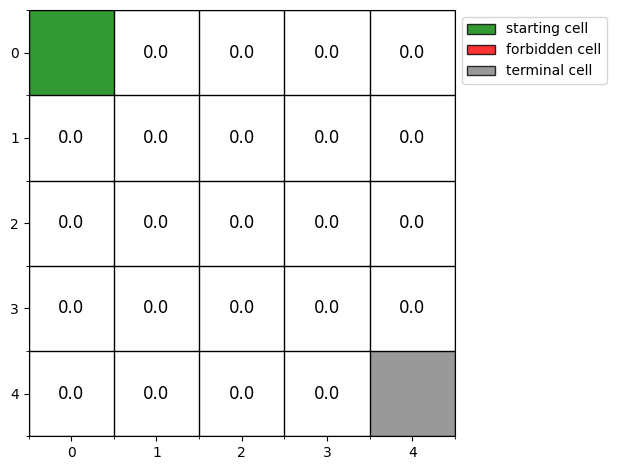

In [3]:
# basic gridworld setup
l = 5      ### length of the gridworld edge (square)
gridworld = np.zeros((l,l))

### start and exit cells
starts = [(0,0)]
ends = [(l-1,l-1)]
forbiddens = []

### action list
actions = ['up','down','left','right']

# results saver
forb = len(forbiddens)
start = starts[0]
end = ends[0]

folder_name = f'{l}x{l}_grid_start_{start}_end_{end}_{forb}'
os.makedirs(folder_name,exist_ok = True)

savepath = folder_name + f'/gridworld'
plot_gridworld(gridworld,starts,forbiddens,ends,gradient = False,actions = [],savepath = savepath)




This is a very basic gridworld with a starting cell and an ending cell, with no forbidden cells in the middle. Let's try to solve this with standard RL approaches such as Monte Carlo. We would like to see as output a gridworld that looks like the one we obtain with **Dynamic Programming** solving:

In [4]:
# DYNAMIC PROGRAMMING EVALUATOR
def dp_eval(gridworld,starts,forbiddens,ends,gamma):
    # initialize V(s) and pi(s) arbitrarily for all of them
    V = np.zeros_like(gridworld)
    l = np.shape(V)[0]
    pi = np.random.randint(4,size = (l,l))     # random actions indexes = 0,1,2,3
    set_of_actions = [(0,1),(0,-1),(-1,0),(1,0)] # up, down, left, right

    # terminal states must have zeros, as well as forbiddens
    for terminal in ends+forbiddens:
        V[terminal[0],terminal[1]]=0

    ####################
    # POLICY ITERATION #
    #################### 
    policy_stable = False
    while policy_stable == False:
        # POLICY EVALUATION LOOP
        theta = 0.1  # accuracy thresh
        delta = 0.5
        while delta > theta:
            delta = 0
            # loop across states
            for x_cell in range(np.shape(gridworld)[0]):
                for y_cell in range(np.shape(gridworld)[1]):
                    
                    # check if analyzed cell is not in prohibited states
                    if (x_cell, y_cell) not in ends+forbiddens:
                        v = V[x_cell,y_cell]
    
                        temp = 0
                        # check if action brings to an illegal cell
                        # if not update value estimate
                        
                        action = set_of_actions[pi[x_cell,y_cell]]
                        new_x = x_cell + action[0] 
                        new_y = y_cell + action[1]
                        if (new_x,new_y) not in forbiddens and new_x >= 0 and new_x < l and new_y >= 0 and new_y < l:
                            temp += -1 + gamma * V[x_cell + action[0],y_cell + action[1]]
                        
                        V[x_cell,y_cell] = temp
                        delta = max(delta,abs(v-temp))
    
        # POLICY IMPROVEMENT LOOP
        policy_stable = True
        # loop across states
        for x_cell in range(np.shape(gridworld)[0]):
            for y_cell in range(np.shape(gridworld)[1]):
                    
                # check if analyzed cell is not in prohibited states
                if (x_cell, y_cell) not in ends+forbiddens:
                    old_action = pi[x_cell,y_cell]
    
                    # check whether the action brings inside a prohibited state or not
                    temp = []
                    valid_actions = []
                    for action_idx in range(len(set_of_actions)):
                        action = set_of_actions[action_idx]
                        new_x = x_cell + action[0] 
                        new_y = y_cell + action[1]
                        if (new_x,new_y) not in forbiddens and new_x >= 0 and new_x < l and new_y >= 0 and new_y < l:
                            temp.append(-1 + gamma * V[new_x, new_y])
                            valid_actions.append(action_idx)
                    
                    best_action = valid_actions[np.argmax(np.array(temp))]
                    pi[x_cell,y_cell] = best_action
                    if best_action != old_action:
                        policy_stable = False
        #print(V)
    # if policy iteration has finished, return results
    for x_cell in range(np.shape(V)[0]):
        for y_cell in range(np.shape(V)[1]):
            V[x_cell,y_cell] = round(V[x_cell,y_cell],2)
    return V, pi   # V ~ V*, pi ~ pi*
    

In [5]:
gamma = 0.8
Vstar, pistar = dp_eval(gridworld,starts,forbiddens,ends,gamma)

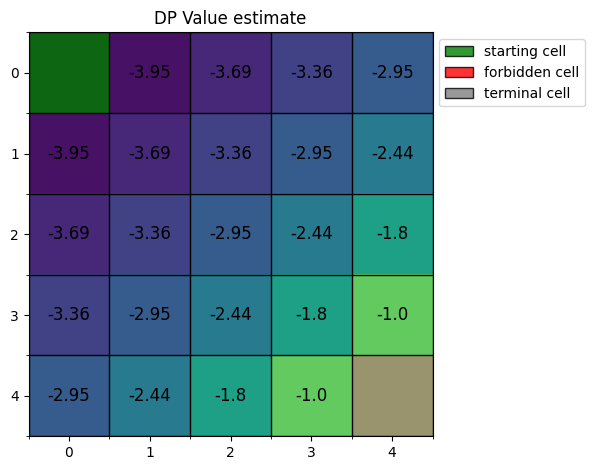

In [6]:
plt.title('DP Value estimate')
savepath = folder_name + f'/gridworld_DP'
plot_gridworld(Vstar,starts,forbiddens,ends,gradient = True,actions = [],savepath=savepath)


## 1.1: Monte Carlo Gridworld solution 
We will now use a MC approach to solve the gridworld. The initial setup for the action value function $Q(s,a)$ is a random initialization (uniform Q for each State/Action pair) and the policy $\pi(s)$ is arbitrary

In [7]:
ACTION_DELTAS = np.array([
    [0, -1],   # up
    [0,  1],   # down
    [-1, 0],   # left
    [1,  0]    # right
])

def monte_carlo_gw_solver(
    gridworld, starts, ends, forbiddens,
    Q, pi, gamma, epsilon,
    total_iter, max_steps, Vstar
):
    l = Q.shape[0]
    n_actions = Q.shape[2]

    forbidden_set = set(map(tuple, forbiddens))
    terminal_set = set(map(tuple, ends))

    returns_count = defaultdict(lambda: defaultdict(int))

    steps = []
    times = []
    Q_est = []

    start_time = time.time()

    for _ in range(total_iter):

        # ---- episode generation ----
        idx = np.random.randint(len(starts))
        curr_s = np.array(starts[idx])

        seen_s = []
        seen_a = []

        for _ in range(max_steps):

            a = np.random.choice(n_actions, p=pi[curr_s[0], curr_s[1]])
            seen_s.append(tuple(curr_s))
            seen_a.append(a)

            new_s = curr_s + ACTION_DELTAS[a]

            # boundary + forbidden check (vectorized & O(1))
            if (
                0 <= new_s[0] < l and
                0 <= new_s[1] < l and
                tuple(new_s) not in forbidden_set
            ):
                curr_s = new_s

            if tuple(curr_s) in terminal_set:
                break

        steps.append(len(seen_s))

        # ---- backward return computation ----
        G = 0
        visited = set()

        for t in reversed(range(len(seen_s))):
            G = gamma * G - 1
            s = seen_s[t]
            a = seen_a[t]

            if (s, a) in visited:
                continue
            visited.add((s, a))

            x, y = s
            count = returns_count[s][a]

            # incremental average (faster form)
            Q[x, y, a] += (G - Q[x, y, a]) / (count + 1)
            returns_count[s][a] += 1

            # epsilon-greedy update (vectorized)
            best_a = np.argmax(Q[x, y])
            pi[x, y] = epsilon / n_actions
            pi[x, y, best_a] += 1 - epsilon

        times.append(time.time() - start_time)
        Q_est.append(np.mean(np.abs(np.max(Q, axis=2) - Vstar)))

    # ---- final extraction (fully vectorized) ----
    Q_star = np.round(np.max(Q, axis=2), 3)
    A_star = np.argmax(Q, axis=2)

    return Q_star, A_star, steps, times, Q_est

Here we run the Monte Carlo algorithm with the set parameters

In [8]:
# initial setup
Q = np.zeros((l,l,len(actions)))   # state:(coor x, coor y), action: up,down,left,right


# setup policy randomly (uniform across all actions)
pi = np.ones((l,l,len(actions)))
for i in range(np.shape(pi)[0]):
    for j in range(np.shape(pi)[1]):
        norm_factor = np.sum(pi[i,j,:])
        pi[i,j,:] = pi[i,j,:] / norm_factor


total_iter = 10000
gamma = 0.8
epsilon = 0.05
max_steps = int(l**3)

mcQ_star, mcA_star, mcsteps, mctimes,Qest = monte_carlo_gw_solver(gridworld,starts,ends,forbiddens,Q,pi,gamma,epsilon,total_iter,max_steps,Vstar)
 

We check the results for MC: in a small gridworld MC is efficient enough in small times

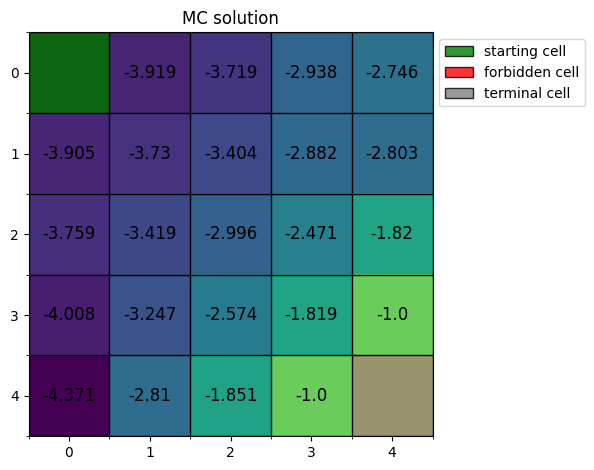

In [9]:
savepath = folder_name + f'/gridworld_MC'
plt.title('MC solution')
plot_gridworld(mcQ_star,starts,forbiddens,ends, gradient = True, actions = [],savepath = savepath)


In [10]:
average_steps = []
for i in range(1,len(mcsteps)):
    average_steps.append(np.mean(np.array(mcsteps[:i])))


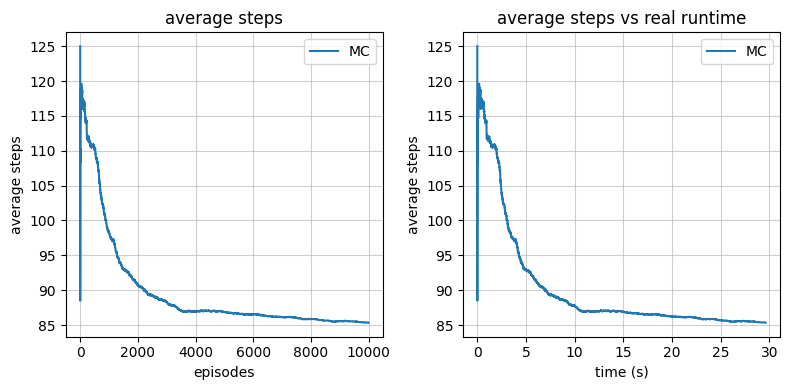

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.plot(np.arange(0,len(average_steps),1),average_steps,label='MC')
ax1.set_title('average steps')
ax1.set_xlabel('episodes')
ax1.set_ylabel('average steps')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes[1:],average_steps,label='MC')
ax2.set_title('average steps vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('average steps')
ax2.legend()
ax2.grid(alpha = 0.6)

savepath = folder_name + f'/avg_steps_MC'
plt.tight_layout()
plt.savefig(savepath)
plt.show()

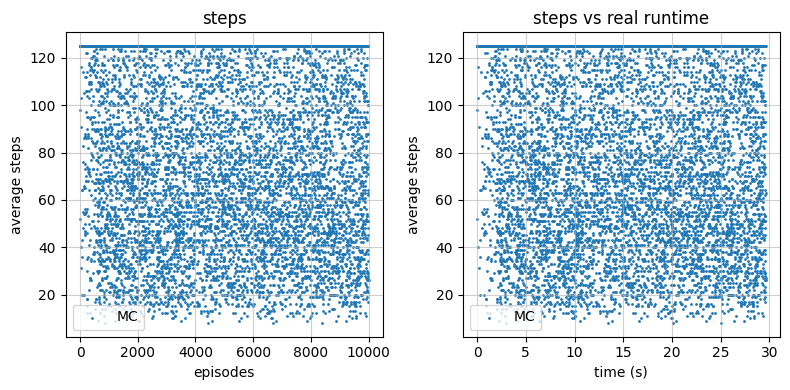

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.scatter(np.arange(0,len(mcsteps),1),mcsteps,label='MC',s=1)
ax1.set_title('steps')
ax1.set_xlabel('episodes')
ax1.set_ylabel('average steps')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.scatter(mctimes,mcsteps,label='MC',s=1)
ax2.set_title('steps vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('average steps')
ax2.legend()
ax2.grid(alpha = 0.6)

savepath = folder_name + f'/steps_MC'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

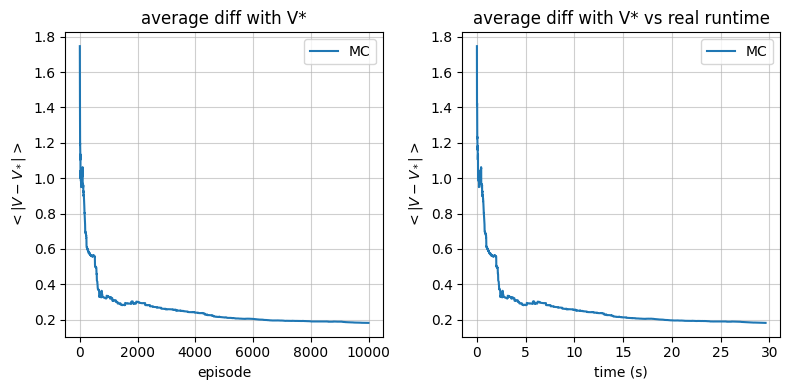

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (8,4))
ax1.plot(np.arange(0,len(Qest),1),Qest,label='MC')
ax1.set_title('average diff with V*')
ax1.set_xlabel('episode')
ax1.set_ylabel(r'$<|V-V_*|>$')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes,Qest,label='MC')
ax2.set_title('average diff with V* vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel(r'$<|V-V_*|>$')
ax2.legend()
ax2.grid(alpha = 0.6)

savepath = folder_name + f'/VVstar_MC'
plt.tight_layout()
plt.savefig(savepath)

plt.show()


## 1.2: TD Learning solution (SARSA TD Control)
Another algorithm that can be used to solve the gridworld, for example **SARSA**. Sarsa is a TD algorithm in the sense that uses new data as soon as they are available to update the policy, instead of waiting until the end of the episode as Monte Carlo does. Regardless of this, at the end of the convergence TD and MC are equivalent, in the sense that they solve the same problem with different approaches, but converge to the same solution.

In [14]:
def SARSA_gw_solver(gridworld,starts,ends,forbiddens,Q,pi,gamma,alpha,epsilon,total_iter,max_steps,Vstar):

    steps = []
    times = []
    Q_est = []
    
    # set terminal states as zeros (integrity)
    for terminal_state in ends:
        Q[terminal_state[0],terminal_state[1],:] = np.zeros(len(Q[terminal_state[0],terminal_state[1],:]))

    l = np.shape(gridworld)[0]
    # all possible actions
    actions = np.arange(0,4,1)   # up down left right

    
    # loop for each episode
    t = 0
    start_time = time.time()
    while t < total_iter:
        step_counter = 0
        t += 1
        # select a random initial state
        start_indices = np.arange(0,len(starts),1)
        start_idx = np.random.choice(start_indices)
        S = starts[start_idx]

        # epsilon greedy action selection
        action_selection_rand = np.random.uniform(0,1)   # if this is lower than epsilon, choose action randomly
        if action_selection_rand < epsilon:              # if not take greedy action
            A = np.random.choice(actions)
        else:                                     # greedy here            
            A = actions[np.argmax(Q[S[0],S[1],:])]
            
        # loop across steps of episode (until S is terminal)
        while S not in ends:
            # take A and observe R, S'
            R = -1 # each step "costs" 1
            step_counter += 1
            
            # actions: up down left right
            if A == 0:
                new_S = (S[0],S[1] + 1)
            elif A == 1:
                new_S = (S[0],S[1] - 1)
            elif A == 2:
                new_S = (S[0] - 1 ,S[1])
            elif A == 3:
                new_S = (S[0] + 1,S[1])
            # check the legality of the new state
            if new_S[0] < 0 or new_S[0] >= l or new_S[1] < 0 or new_S[1] >= l or new_S in forbiddens:
                new_S = S

            # now we know new_S is legal, we shall determine new_A from new_S according to pi
            # epsilon greedy action selection
            action_selection_rand = np.random.uniform(0,1)   # if this is lower than epsilon, choose action randomly
            if action_selection_rand < epsilon:              # if not take greedy action
                new_A = np.random.choice(actions)
            else:                                     # greedy here
                new_A = actions[np.argmax(Q[new_S[0],new_S[1],:])]

            # update State-Action value
            Q[S[0],S[1],A] = Q[S[0],S[1],A] + alpha * (R + gamma * Q[new_S[0],new_S[1],new_A] - Q[S[0],S[1],A])

            # update State and Action
            S = new_S
            A = new_A

        # append to final lists
        steps.append(step_counter)
        times.append(time.time()-start_time)

        Q_est.append(np.mean(np.abs(np.max(Q,axis = 2)-Vstar)))

        #print(Q)
    Q_star = np.zeros((l,l))
    A_star = np.zeros((l,l))
    for x_coor in range(np.shape(Q)[0]):
        for y_coor in range(np.shape(Q)[1]):
            Q_star[x_coor,y_coor] = round(np.max(Q[x_coor,y_coor,:]),3)
            A_star[x_coor,y_coor] = np.argmax(Q[x_coor,y_coor,:])
    
    # return results
    # final Q, final A, returns, times
    return Q_star, A_star, steps, times, Q_est
        

In [15]:
# initial setup
Q = np.zeros((l,l,len(actions)))    # state:(coor x, coor y), action: up,down,left,right

# setup policy randomly (uniform across all actions)
pi = np.ones((l,l,len(actions)))
for i in range(np.shape(pi)[0]):
    for j in range(np.shape(pi)[1]):
        norm_factor = np.sum(pi[i,j,:])
        pi[i,j,:] = pi[i,j,:] / norm_factor


total_iter = 10000
gamma = 0.8
alpha = 0.1 # step size
epsilon = 0.05
max_steps = int(l**3)



SARSAQ_star, SARSAA_star, SARSA_steps, SARSA_times, SARSA_Q_est = SARSA_gw_solver(gridworld,starts,ends,forbiddens,Q,pi,gamma,alpha,epsilon,total_iter,max_steps,Vstar)
 

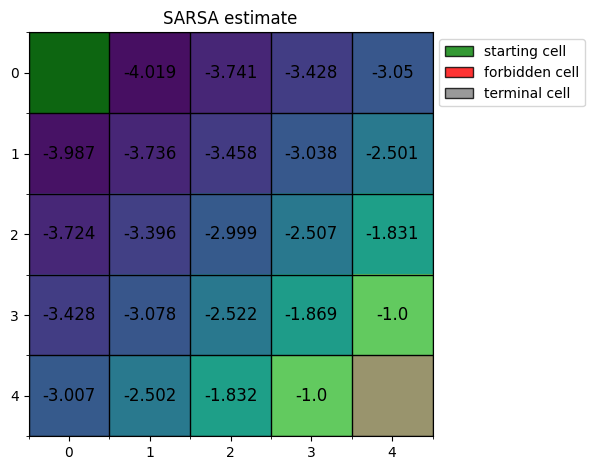

In [16]:
plt.title('SARSA estimate')
savepath = folder_name + f'/gridworld_SARSA'

plot_gridworld(SARSAQ_star,starts,forbiddens,ends,gradient = True,actions = [],savepath= savepath)


Let's compare results gotten with MC and SARSA

In [17]:
average_steps_SARSA = []
for i in range(1,len(SARSA_steps)):
    average_steps_SARSA.append(np.mean(np.array(SARSA_steps[:i])))


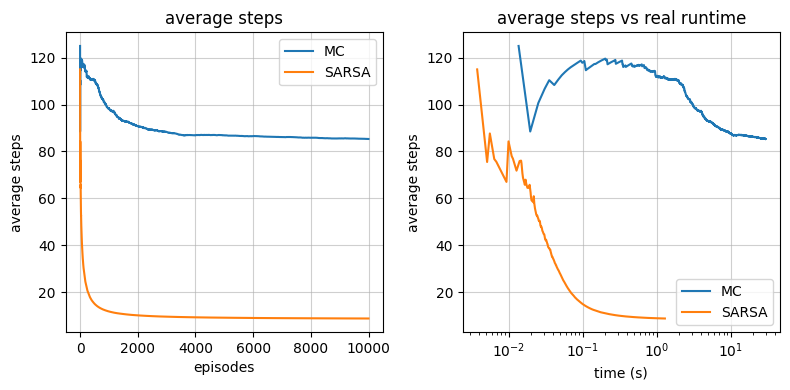

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.plot(np.arange(0,len(average_steps),1),average_steps,label='MC')
ax1.plot(np.arange(0,len(average_steps_SARSA),1),average_steps_SARSA,label='SARSA')
ax1.set_title('average steps')
ax1.set_xlabel('episodes')
ax1.set_ylabel('average steps')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes[1:],average_steps,label='MC')
ax2.plot(SARSA_times[1:],average_steps_SARSA,label='SARSA')
ax2.set_title('average steps vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('average steps')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.legend()

savepath = folder_name + f'/avg_steps_MC_SARSA'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

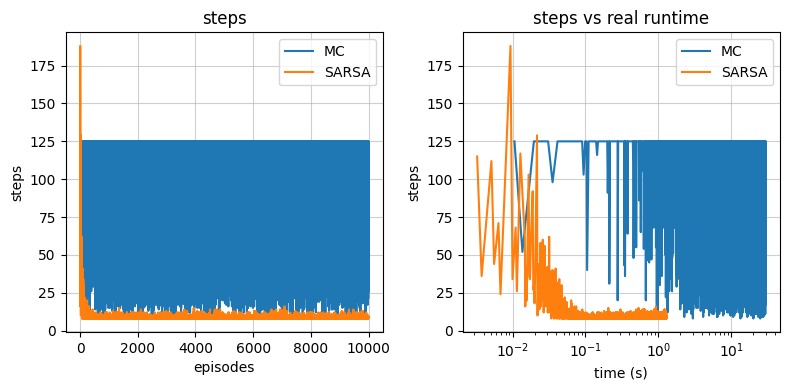

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.plot(np.arange(0,len(mcsteps),1),mcsteps,label='MC')
ax1.plot(np.arange(0,len(SARSA_steps),1),SARSA_steps,label='SARSA')
ax1.set_title('steps')
ax1.set_xlabel('episodes')
ax1.set_ylabel('steps')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes,mcsteps,label='MC')
ax2.plot(SARSA_times,SARSA_steps,label='SARSA')
ax2.set_title('steps vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('steps')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.legend()

savepath = folder_name + f'/steps_MC_SARSA'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

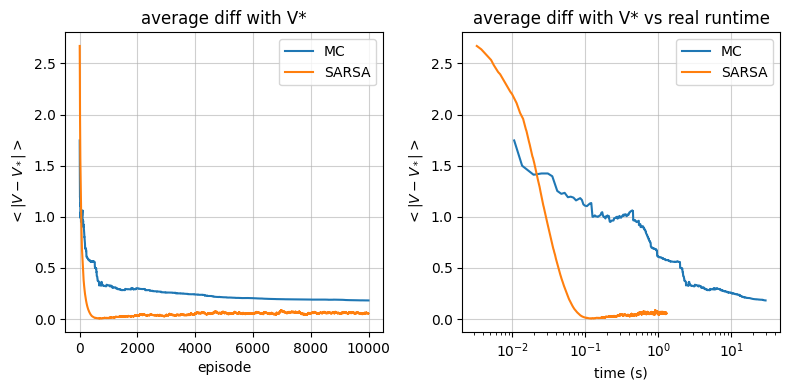

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))

ax1.plot(np.arange(0,len(Qest),1),Qest,label='MC')
ax1.plot(np.arange(0,len(SARSA_Q_est),1),SARSA_Q_est,label='SARSA')
ax1.set_title('average diff with V*')
ax1.set_xlabel('episode')
ax1.set_ylabel(r'$<|V-V_*|>$')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes,Qest,label='MC')
ax2.plot(SARSA_times,SARSA_Q_est,label='SARSA')
ax2.set_title('average diff with V* vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel(r'$<|V-V_*|>$')
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.set_xscale('log')

savepath = folder_name + f'/Vvstar_MC_SARSA'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

## 1.3 PILCO solution
PILCO is a model based data-efficient Bayesian RL approach to policy search. It is able to reduce model bias, which is one of the key problems of model-based RL. PILCO can cope with very little data and facilitates learning with only a few episodes available. It uses Gaussian Processes to learn a probabilistic dynamics model, then optimize it through analytic gradient computation

In [21]:
# initial setup
Q = np.zeros((l,l,len(actions)))    # state:(coor x, coor y), action: up,down,left,right

# setup policy randomly (uniform across all actions)
pi = np.ones((l,l,len(actions)))
for i in range(np.shape(pi)[0]):
    for j in range(np.shape(pi)[1]):
        norm_factor = np.sum(pi[i,j,:])
        pi[i,j,:] = pi[i,j,:] / norm_factor


PILCO_iter = 5
exploring_episodes = 10
max_steps = int(l**3)
gamma = 0.8



In [22]:
def PILCO(gridworld,forbiddens,ends,exploring_episodes,PILCO_iter,max_steps,gamma):
    env = GridWorld(
        grid = gridworld,
        forbidden_cells = forbiddens,
        terminal_cells = ends
    )
    
    # policy definition
    policy = RBFPolicy(
        n_actions=env.n_actions,
        n_rows=env.n_rows,
        n_cols=env.n_cols,
        forbidden_cells=forbiddens
    )

    # lists to save data
    rewards = []
    episodes = []
    times = []
    steps = []
    Qs = []
    
    # Warm-start policy weights using BFS distances so the optimizer
        # starts near a sensible solution rather than a flat zero.
    _warm_start_policy(policy, env)
    # counter for episodes
    episodes_run = 0
    
    # --- Phase 1: Initial random data collection ---
    start_time = time.time()
    print("\n[Phase 0] Collecting initial random data...")
    X_all, Y_all, _ = collect_data_random(env, n_episodes=exploring_episodes, max_steps=max_steps)
    print(f"  Collected {len(X_all)} transitions.")
    episodes_run += exploring_episodes
    
    n_pilco_iterations = PILCO_iter

    for iteration in range(n_pilco_iterations):
        # --- Step 1: Fit GP dynamics model ---
        gp_models = fit_gp_models(X_all, Y_all, state_dim=env.state_dim)
    
        # --- Step 2: Optimize policy ---
        optimize_policy(policy, gp_models, env, T=15, gamma=gamma, n_restarts=2)
    
        # --- Step 3: Evaluate current policy ---
        success_rate, avg_reward,step_count = evaluate_policy(env, policy, n_episodes=exploring_episodes)
        visualize_policy(env, policy)
        idx = np.random.choice(np.arange(0,len(starts),1))
        s0 = starts[idx]
        
        q_eval = compute_q(s0,1,gp_models,policy,env)        #  (np.random.choice(starts),1,gp_models,policy,env)
        rewards.append(avg_reward)
        episodes.append(episodes_run)
        times.append(time.time()-start_time)
        steps.append(step_count)
        Qs.append(q_eval)
    
        # --- Step 4: Collect new data with current policy ---
        X_new, Y_new, ep_reward = collect_data_policy(env, policy, n_episodes=exploring_episodes)
        episodes_run += exploring_episodes
        print(f"  Collected {len(X_new)} new transitions. Episode reward: {ep_reward:.2f}")
    
        # Aggregate data
        X_all = np.vstack([X_all, X_new])
        Y_all = np.vstack([Y_all, Y_new])
        print(f"  Total dataset size: {len(X_all)} transitions.")
    
        if success_rate >= 0.9:
            print("\n  *** Policy converged! Success rate >= 90% ***")
            break
    
    success_rate, avg_reward, step_count = evaluate_policy(env, policy, n_episodes=50)
    print(f"  Final success rate: {success_rate * 100:.1f}%  |  Avg reward: {avg_reward:.2f}")
    visualize_policy(env, policy)

    return env, policy, rewards, episodes, times, steps,Qs

In [23]:
PILCO_env, PILCO_policy, PILCO_rewards, PILCO_episodes, PILCO_times,PILCO_steps, PILCO_q = PILCO(gridworld,forbiddens,ends,exploring_episodes,PILCO_iter,max_steps,gamma)
 


[Phase 0] Collecting initial random data...
  Collected 118 transitions.
  Fitting GP for dimension 0...
  Fitting GP for dimension 1...
  Policy optimized. Expected cost: 3.5692

  Greedy policy (T=terminal, X=forbidden):
   →  ↓  ↓  ↓  ↓ 
   →  →  ↓  ↓  ↓ 
   →  →  ↓  ↓  ↓ 
   →  →  →  ↓  ↓ 
   →  →  →  →  T 

  Collected 82 new transitions. Episode reward: 28.00
  Total dataset size: 200 transitions.

  *** Policy converged! Success rate >= 90% ***
  Final success rate: 100.0%  |  Avg reward: 3.00

  Greedy policy (T=terminal, X=forbidden):
   →  ↓  ↓  ↓  ↓ 
   →  →  ↓  ↓  ↓ 
   →  →  ↓  ↓  ↓ 
   →  →  →  ↓  ↓ 
   →  →  →  →  T 



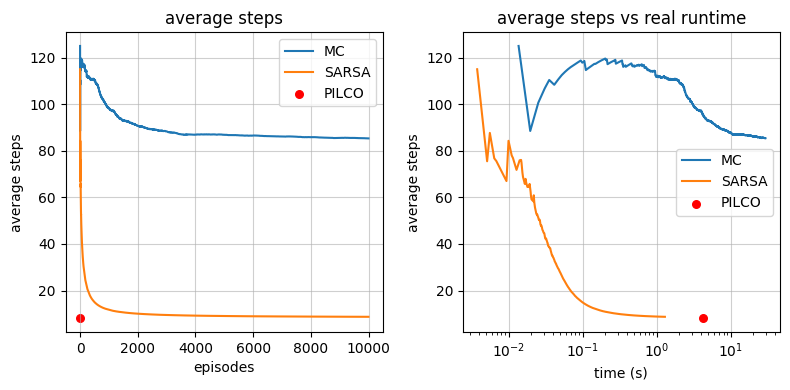

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.plot(np.arange(0,len(average_steps),1),average_steps,label='MC')
ax1.plot(np.arange(0,len(average_steps_SARSA),1),average_steps_SARSA,label='SARSA')
ax1.scatter(PILCO_episodes,PILCO_steps,label = 'PILCO', s = 30,c='red')
ax1.set_title('average steps')
ax1.set_xlabel('episodes')
ax1.set_ylabel('average steps')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes[1:],average_steps,label='MC')
ax2.plot(SARSA_times[1:],average_steps_SARSA,label='SARSA')
ax2.scatter(PILCO_times,PILCO_steps,label = 'PILCO', s = 30, c= 'red')
ax2.set_title('average steps vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('average steps')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.legend()

savepath = folder_name + f'/avg_steps_MC_SARSA_PILCO'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

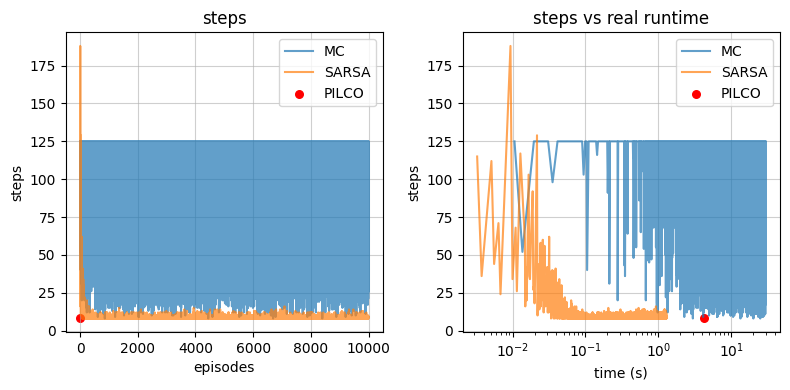

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.plot(np.arange(0,len(mcsteps),1),mcsteps,label='MC',alpha = 0.7)
ax1.plot(np.arange(0,len(SARSA_steps),1),SARSA_steps,label='SARSA', alpha = 0.7)
ax1.scatter(PILCO_episodes,PILCO_steps,label = 'PILCO', s = 30,c='red')
ax1.set_title('steps')
ax1.set_xlabel('episodes')
ax1.set_ylabel('steps')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes,mcsteps,label='MC',alpha = 0.7)
ax2.plot(SARSA_times,SARSA_steps,label='SARSA', alpha = 0.7)
ax2.scatter(PILCO_times,PILCO_steps,label = 'PILCO', s = 30, c= 'red')
ax2.set_title('steps vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('steps')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.legend()

savepath = folder_name + f'/steps_MC_SARSA_PILCO'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

In [26]:
best_steps = float(l*2-2)

MC_best = np.where(np.array(mcsteps) == best_steps)[0]
if len(MC_best != 0):
    MC_best = MC_best[0]
    MC_best_time = mctimes[int(MC_best)]
else:
    MC_best = None
    MC_best_time = None

SARSA_best = np.where(np.array(SARSA_steps) == best_steps)[0]
if len(SARSA_best != 0):
    SARSA_best = SARSA_best[0]
    SARSA_best_time = SARSA_times[int(SARSA_best)]
else:
    SARSA_best = None
    SARSA_best_time = None

PILCO_best = np.where(np.array(PILCO_steps) == float(best_steps))[0]
if len(PILCO_best != 0):
    PILCO_best = PILCO_best[0]
    PILCO_best_time = PILCO_times[int(PILCO_best)]
else:
    PILCO_best = None
    PILCO_best_time = None

In [27]:

# results log log_path = folder_path+f'/event_log.txt'
log_path = folder_name + '/results_log.txt'

# starting cells
sc_str = ''
for sc in starts:
    sc_str = sc_str + str(sc) + '_'

# terminal cells
ter_str = ''
for tr in ends:
    ter_str = ter_str + str(tr) + '_'

# forbidden cells
for_str = ''
for fo in forbiddens:
    for_str = for_str + str(fo) + '_'

with open(log_path,"w") as text_file:
    print(f"### CELLS ###",file = text_file)
    print(f"Starting cells: " + sc_str,file = text_file)
    print(f"Terminal cells: " + ter_str,file = text_file)
    print(f"Forbidden cells: " + for_str,file = text_file)
    print(f'######',file = text_file)
    print(f'best path is long: {best_steps}',file = text_file)
    print(f'First MC episode (index) with best length: {MC_best}',file = text_file)
    print(f'At time: {MC_best_time}',file = text_file)
    print(f'First SARSA episode (index) with best length: {SARSA_best}',file = text_file)
    print(f'At time: {SARSA_best_time}',file = text_file)
    print(f'First PILCO episode (index) with best length: {PILCO_best}',file = text_file)
    print(f'At time: {PILCO_best_time}',file = text_file)
    
    

## 2: A more complex gridworld example

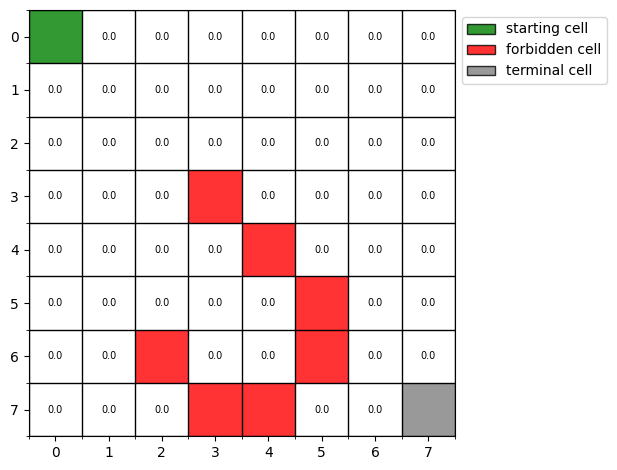

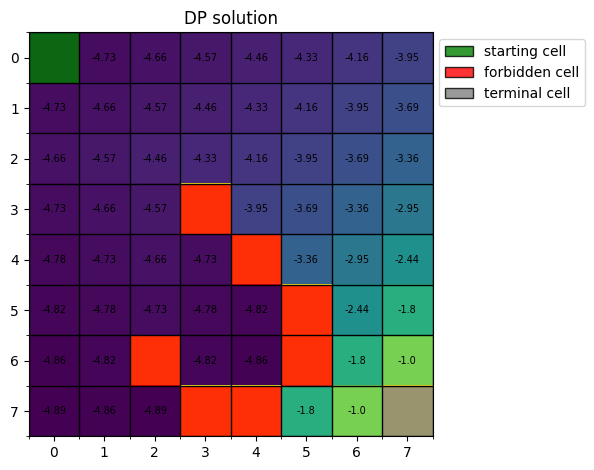

In [28]:
# basic gridworld setup
l = 8      ### length of the gridworld edge (square)
gridworld = np.zeros((l,l))

### start and exit cells
starts = [(0,0)]
ends = [(l-1,l-1)]
forbiddens = [(3,3),(4,4),(5,5),(6,5),(7,3),(6,2),(7,4)]

### action list
actions = ['up','down','left','right']

Vstar, pistar = dp_eval(gridworld,starts,forbiddens,ends,gamma)


# save data
forb = len(forbiddens)
folder_name = f'{l}x{l}_grid_start_{start}_end_{end}_{forb}'
os.makedirs(folder_name,exist_ok = True)
savepath = folder_name + f'/gridworld'
plt.tight_layout()
plt.savefig(savepath)

plot_gridworld(gridworld,starts,forbiddens,ends,gradient = False,actions = [],savepath = savepath)
plt.title('DP solution')
savepath = folder_name + f'/gridworld_DP'
plot_gridworld(Vstar,starts,forbiddens,ends,gradient = True,actions = [],savepath = savepath)


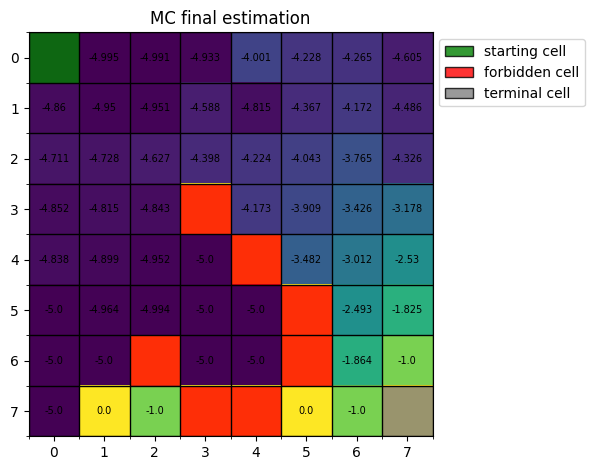

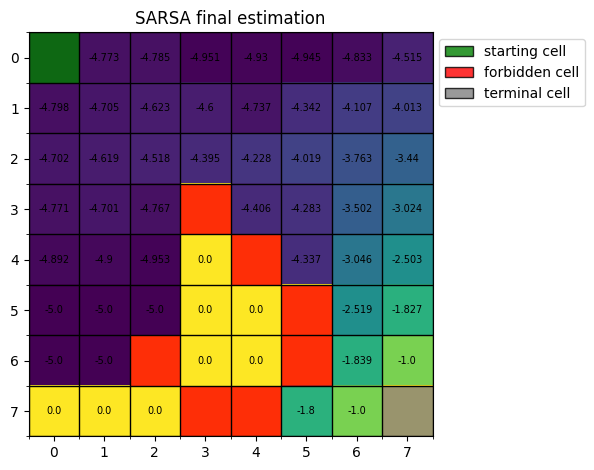

In [29]:
# initial setup
Q = np.zeros((l,l,len(actions)))   # state:(coor x, coor y), action: up,down,left,right


# setup policy randomly (uniform across all actions)
pi = np.ones((l,l,len(actions)))
for i in range(np.shape(pi)[0]):
    for j in range(np.shape(pi)[1]):
        norm_factor = np.sum(pi[i,j,:])
        pi[i,j,:] = pi[i,j,:] / norm_factor


max_steps = int(l**3) * 2
total_iter = 10000
gamma = 0.8
epsilon = 0.05

mcQ_star, mcA_star, mcsteps, mctimes,Qest = monte_carlo_gw_solver(gridworld,starts,ends,forbiddens,Q,pi,gamma,epsilon,total_iter,max_steps,Vstar)
plt.title('MC final estimation')
savepath = folder_name + f'/gridworld_MC'
plot_gridworld(mcQ_star,starts,forbiddens,ends, gradient = True, actions = [],savepath = savepath)

Q = np.zeros((l,l,len(actions)))   # state:(coor x, coor y), action: up,down,left,right


# setup policy randomly (uniform across all actions)
pi = np.ones((l,l,len(actions)))
for i in range(np.shape(pi)[0]):
    for j in range(np.shape(pi)[1]):
        norm_factor = np.sum(pi[i,j,:])
        pi[i,j,:] = pi[i,j,:] / norm_factor



SARSA_Q_star, SARSA_A_star, SARSA_steps, SARSA_times,SARSA_Qest = monte_carlo_gw_solver(gridworld,starts,ends,forbiddens,Q,pi,gamma,epsilon,total_iter,max_steps,Vstar)
plt.title('SARSA final estimation')
savepath = folder_name + f'/gridworld_SARSA'
plot_gridworld(SARSA_Q_star,starts,forbiddens,ends, gradient = True, actions = [],savepath = savepath)



In [30]:
# PILCO solution

PILCO_iter = 5
exploring_episodes = 20
max_steps = int(l**3) * 2
gamma = 0.8

PILCO_env, PILCO_policy, PILCO_rewards, PILCO_episodes, PILCO_times,PILCO_steps, PILCO_q = PILCO(gridworld,forbiddens,ends,exploring_episodes,PILCO_iter,max_steps,gamma)



[Phase 0] Collecting initial random data...
  Collected 365 transitions.
  Fitting GP for dimension 0...
  Fitting GP for dimension 1...
  Policy optimized. Expected cost: 4.8241

  Greedy policy (T=terminal, X=forbidden):
   ←  ←  ←  ←  ↑  ↑  ↑  → 
   ←  ←  ←  ←  ←  ↑  ↑  → 
   ←  ←  ←  ←  ←  ←  ↑  → 
   ←  ←  ←  X  ←  ↑  →  → 
   ←  ←  ↑  ↑  X  ↑  ↑  → 
   ←  ↑  ↑  ↑  ↑  X  ↑  ↑ 
   ←  ↑  X  ←  ←  X  ↑  ↑ 
   ↑  ↑  ←  X  X  ←  ←  T 

  Collected 600 new transitions. Episode reward: -1788.00
  Total dataset size: 965 transitions.
  Fitting GP for dimension 0...
  Fitting GP for dimension 1...
  Policy optimized. Expected cost: 4.8241

  Greedy policy (T=terminal, X=forbidden):
   ←  ←  ←  ←  ↑  ↑  ↑  → 
   ←  ←  ←  ←  ←  ↑  ↑  → 
   ←  ←  ←  ←  ←  ←  ↑  → 
   ←  ←  ←  X  ←  ↑  →  → 
   ←  ←  ↑  ↑  X  ↑  ↑  → 
   ←  ↑  ↑  ↑  ↑  X  ↑  ↑ 
   ←  ↑  X  ←  ←  X  ↑  ↑ 
   ↑  ↑  ←  X  X  ←  ←  T 

  Collected 600 new transitions. Episode reward: -699.00
  Total dataset size: 1565 transitions

In [31]:
# compute average steps
average_steps_MC = []
average_steps_SARSA = []
for i in range(1,len(mcsteps)):
    average_steps_MC.append(np.mean(np.array(mcsteps[:i])))
    
for i in range(1,len(SARSA_steps)):
    average_steps_SARSA.append(np.mean(np.array(SARSA_steps[:i])))



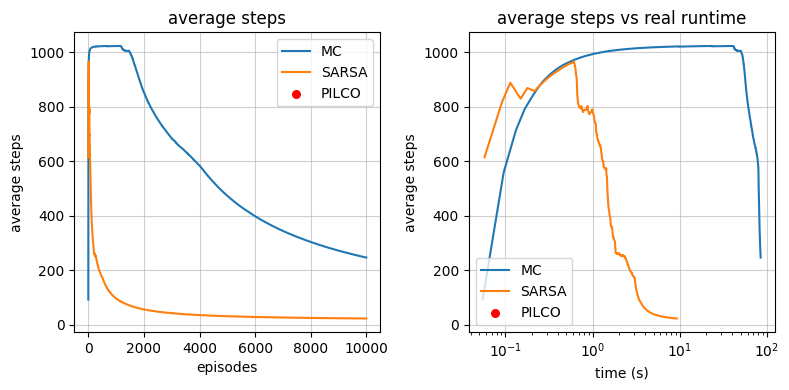

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.plot(np.arange(0,len(average_steps_MC),1),average_steps_MC,label='MC')
ax1.plot(np.arange(0,len(average_steps_SARSA),1),average_steps_SARSA,label='SARSA')
ax1.scatter(PILCO_episodes,PILCO_steps,s = 30, c = 'red',label = 'PILCO')
ax1.set_title('average steps')
ax1.set_xlabel('episodes')
ax1.set_ylabel('average steps')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes[1:],average_steps_MC,label='MC')
ax2.plot(SARSA_times[1:],average_steps_SARSA,label='SARSA')
ax2.scatter(PILCO_times,PILCO_steps,s = 30, c = 'red',label = 'PILCO')
ax2.set_title('average steps vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('average steps')
ax2.legend()
ax2.set_xscale('log')
ax2.grid(alpha = 0.6)

savepath = folder_name + f'/average_steps_MC_SARSA_PILCO'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

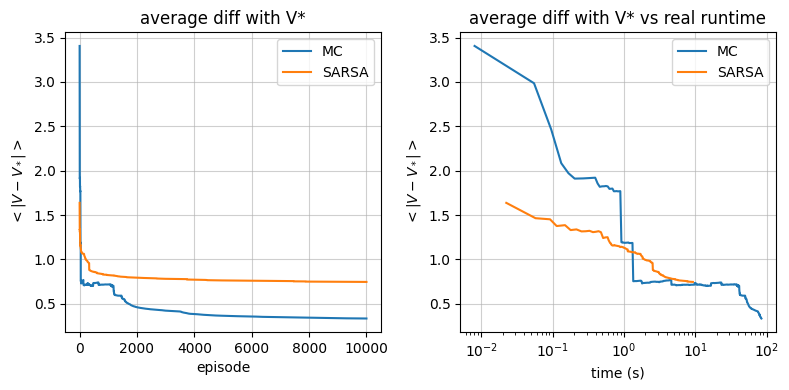

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (8,4))

ax1.plot(np.arange(0,len(Qest),1),Qest,label='MC')
ax1.plot(np.arange(0,len(SARSA_Qest),1),SARSA_Qest,label='SARSA')
ax1.set_title('average diff with V*')
ax1.set_xlabel('episode')
ax1.set_ylabel(r'$<|V-V_*|>$')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes,Qest,label='MC')
ax2.plot(SARSA_times,SARSA_Qest,label='SARSA')
ax2.set_title('average diff with V* vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel(r'$<|V-V_*|>$')
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.set_xscale('log')

savepath = folder_name + f'/VVstar_MC_SARSA_PILCO'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

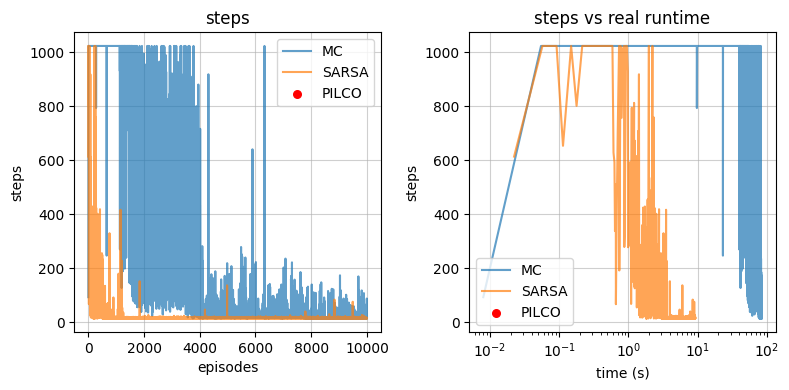

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.plot(np.arange(0,len(mcsteps),1),mcsteps,label='MC',alpha = 0.7)
ax1.plot(np.arange(0,len(SARSA_steps),1),SARSA_steps,label='SARSA', alpha = 0.7)
ax1.scatter(PILCO_episodes,PILCO_steps,label = 'PILCO', s = 30,c='red')
ax1.set_title('steps')
ax1.set_xlabel('episodes')
ax1.set_ylabel('steps')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes,mcsteps,label='MC',alpha = 0.7)
ax2.plot(SARSA_times,SARSA_steps,label='SARSA', alpha = 0.7)
ax2.scatter(PILCO_times,PILCO_steps,label = 'PILCO', s = 30, c= 'red')
ax2.set_title('steps vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('steps')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.legend()

savepath = folder_name + f'/steps_MC_SARSA_PILCO'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

In [35]:
best_steps = float(l*2-2)

MC_best = np.where(np.array(mcsteps) == best_steps)[0]
if len(MC_best != 0):
    MC_best = MC_best[0]
    MC_best_time = mctimes[int(MC_best)]
else:
    MC_best = None
    MC_best_time = None

SARSA_best = np.where(np.array(SARSA_steps) == best_steps)[0]
if len(SARSA_best != 0):
    SARSA_best = SARSA_best[0]
    SARSA_best_time = SARSA_times[int(SARSA_best)]
else:
    SARSA_best = None
    SARSA_best_time = None

PILCO_best = np.where(np.array(PILCO_steps) == float(best_steps))[0]
if len(PILCO_best != 0):
    PILCO_best = PILCO_best[0]
    PILCO_best_time = PILCO_times[int(PILCO_best)]
else:
    PILCO_best = None
    PILCO_best_time = None
# results log log_path = folder_path+f'/event_log.txt'
log_path = folder_name + '/results_log.txt'

# starting cells
sc_str = ''
for sc in starts:
    sc_str = sc_str + str(sc) + '_'

# terminal cells
ter_str = ''
for tr in ends:
    ter_str = ter_str + str(tr) + '_'

# forbidden cells
for_str = ''
for fo in forbiddens:
    for_str = for_str + str(fo) + '_'

with open(log_path,"w") as text_file:
    print(f"### CELLS ###",file = text_file)
    print(f"Starting cells: " + sc_str,file = text_file)
    print(f"Terminal cells: " + ter_str,file = text_file)
    print(f"Forbidden cells: " + for_str,file = text_file)
    print(f'######',file = text_file)
    print(f'best path is long: {best_steps}',file = text_file)
    print(f'First MC episode (index) with best length: {MC_best}',file = text_file)
    print(f'At time: {MC_best_time}',file = text_file)
    print(f'First SARSA episode (index) with best length: {SARSA_best}',file = text_file)
    print(f'At time: {SARSA_best_time}',file = text_file)
    print(f'First PILCO episode (index) with best length: {PILCO_best}',file = text_file)
    print(f'At time: {PILCO_best_time}',file = text_file)
    
    

## 3: The maze
We are now creating a gridworld in a sort of "maze", that is supposedly difficult to exit with mere random exploration

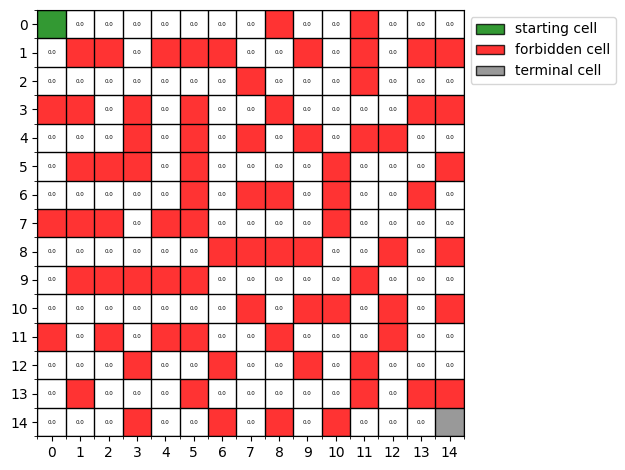

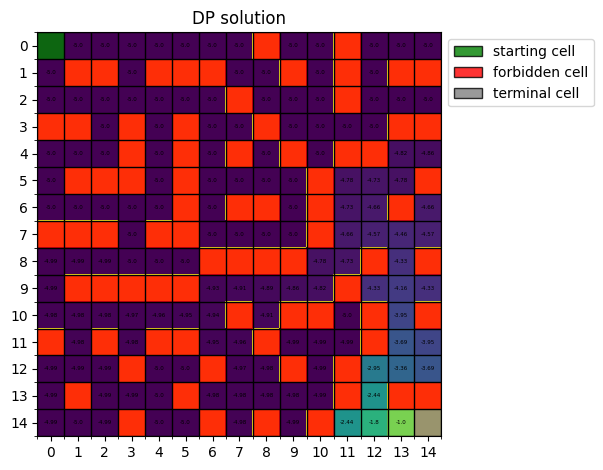

In [36]:
# basic gridworld setup
l = 15    ### length of the gridworld edge (square)
gridworld = np.zeros((l,l))

### start and exit cells
starts = [(0,0)]
ends = [(l-1,l-1)]
forbiddens = [(13,14),(13,13),(10,14),(8,14),(8,12),(6,13),(5,14),(13,11),(10,12),(11,12),(12,11),(14,10),(10,10),(14,8),(12,9),(9,11),(11,8),(10,9),(10,7),(13,5),(13,1),(14,3),(12,3),(11,4),(11,5),(14,6),(12,6),(11,0),(11,2),(5,2),(5,1),(7,0),(9,1),(9,2),(9,3),(9,4),(9,5),(7,1),(7,2),(7,4),(6,10),(7,10),(8,9),(8,8),(6,8),(6,7),(8,7),(8,6),(5,5),(6,5),(7,5),(4,5),(4,7),(4,11),(4,12),(5,10),(4,9),(3,8),(2,7),(4,3),(5,3),(3,3),(3,5),(3,0),(3,1),(3,13),(3,14),(1,13),(1,14),(1,11),(2,11),(1,1),(1,2),(1,4),(1,5),(1,6),(0,8),(1,9),(0,11)]

### action list
actions = ['up','down','left','right']

Vstar, pistar = dp_eval(gridworld,starts,forbiddens,ends,gamma)


# save data
forb = len(forbiddens)
folder_name = f'{l}x{l}_grid_start_{start}_end_{end}_{forb}'
os.makedirs(folder_name,exist_ok = True)
savepath = folder_name + f'/gridworld'
plt.tight_layout()
plt.savefig(savepath)

plot_gridworld(gridworld,starts,forbiddens,ends,gradient = False,actions = [],savepath = savepath)
plt.title('DP solution')
savepath = folder_name + f'/gridworld_DP'
plot_gridworld(Vstar,starts,forbiddens,ends,gradient = True,actions = [],savepath = savepath)


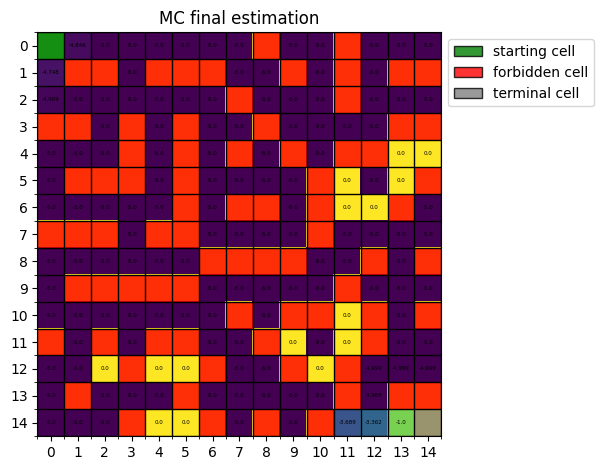

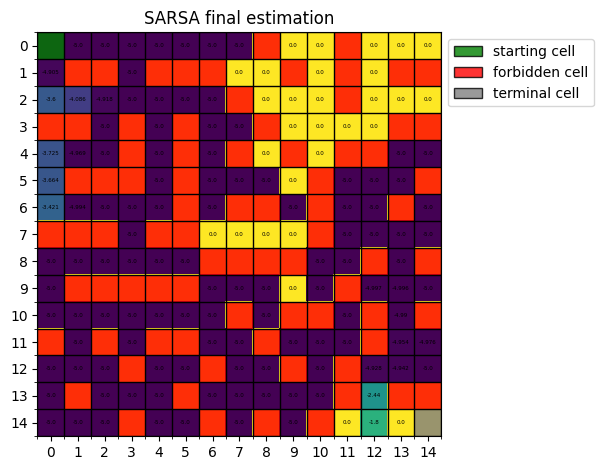

In [40]:
# initial setup
Q = np.zeros((l,l,len(actions)))   # state:(coor x, coor y), action: up,down,left,right

# setup policy randomly (uniform across all actions)
pi = np.ones((l,l,len(actions)))
for i in range(np.shape(pi)[0]):
    for j in range(np.shape(pi)[1]):
        norm_factor = np.sum(pi[i,j,:])
        pi[i,j,:] = pi[i,j,:] / norm_factor

max_steps = int(l**3) * 4
total_iter = 100
gamma = 0.8
epsilon = 0.05

mcQ_star, mcA_star, mcsteps, mctimes,Qest = monte_carlo_gw_solver(gridworld,starts,ends,forbiddens,Q,pi,gamma,epsilon,total_iter,max_steps,Vstar)
plt.title('MC final estimation')
savepath = folder_name + f'/gridworld_MC'
plot_gridworld(mcQ_star,starts,forbiddens,ends, gradient = True, actions = [],savepath = savepath)

Q = np.zeros((l,l,len(actions)))   # state:(coor x, coor y), action: up,down,left,right

# setup policy randomly (uniform across all actions)
pi = np.ones((l,l,len(actions)))
for i in range(np.shape(pi)[0]):
    for j in range(np.shape(pi)[1]):
        norm_factor = np.sum(pi[i,j,:])
        pi[i,j,:] = pi[i,j,:] / norm_factor



SARSA_Q_star, SARSA_A_star, SARSA_steps, SARSA_times,SARSA_Qest = monte_carlo_gw_solver(gridworld,starts,ends,forbiddens,Q,pi,gamma,epsilon,total_iter,max_steps,Vstar)
plt.title('SARSA final estimation')
savepath = folder_name + f'/gridworld_SARSA'
plot_gridworld(SARSA_Q_star,starts,forbiddens,ends, gradient = True, actions = [],savepath = savepath)



In [ ]:
# PILCO solution

PILCO_iter = 5
exploring_episodes = 20
max_steps = int(l**3) * 2
gamma = 0.8

PILCO_env, PILCO_policy, PILCO_rewards, PILCO_episodes, PILCO_times,PILCO_steps, PILCO_q = PILCO(gridworld,forbiddens,ends,exploring_episodes,PILCO_iter,max_steps,gamma)



[Phase 0] Collecting initial random data...
  Collected 1311 transitions.
  Fitting GP for dimension 0...


In [ ]:
# compute average steps
average_steps_MC = []
average_steps_SARSA = []
for i in range(1,len(mcsteps)):
    average_steps_MC.append(np.mean(np.array(mcsteps[:i])))
    
for i in range(1,len(SARSA_steps)):
    average_steps_SARSA.append(np.mean(np.array(SARSA_steps[:i])))



In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.plot(np.arange(0,len(average_steps_MC),1),average_steps_MC,label='MC')
ax1.plot(np.arange(0,len(average_steps_SARSA),1),average_steps_SARSA,label='SARSA')
ax1.scatter(PILCO_episodes,PILCO_steps,s = 30, c = 'red',label = 'PILCO')
ax1.set_title('average steps')
ax1.set_xlabel('episodes')
ax1.set_ylabel('average steps')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes[1:],average_steps_MC,label='MC')
ax2.plot(SARSA_times[1:],average_steps_SARSA,label='SARSA')
ax2.scatter(PILCO_times,PILCO_steps,s = 30, c = 'red',label = 'PILCO')
ax2.set_title('average steps vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('average steps')
ax2.legend()
ax2.set_xscale('log')
ax2.grid(alpha = 0.6)

savepath = folder_name + f'/average_steps_MC_SARSA_PILCO'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (8,4))

ax1.plot(np.arange(0,len(Qest),1),Qest,label='MC')
ax1.plot(np.arange(0,len(SARSA_Qest),1),SARSA_Qest,label='SARSA')
ax1.set_title('average diff with V*')
ax1.set_xlabel('episode')
ax1.set_ylabel(r'$<|V-V_*|>$')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes,Qest,label='MC')
ax2.plot(SARSA_times,SARSA_Qest,label='SARSA')
ax2.set_title('average diff with V* vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel(r'$<|V-V_*|>$')
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.set_xscale('log')

savepath = folder_name + f'/VVstar_MC_SARSA_PILCO'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.plot(np.arange(0,len(mcsteps),1),mcsteps,label='MC',alpha = 0.7)
ax1.plot(np.arange(0,len(SARSA_steps),1),SARSA_steps,label='SARSA', alpha = 0.7)
ax1.scatter(PILCO_episodes,PILCO_steps,label = 'PILCO', s = 30,c='red')
ax1.set_title('steps')
ax1.set_xlabel('episodes')
ax1.set_ylabel('steps')
ax1.legend()
ax1.grid(alpha = 0.6)

ax2.plot(mctimes,mcsteps,label='MC',alpha = 0.7)
ax2.plot(SARSA_times,SARSA_steps,label='SARSA', alpha = 0.7)
ax2.scatter(PILCO_times,PILCO_steps,label = 'PILCO', s = 30, c= 'red')
ax2.set_title('steps vs real runtime')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('steps')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.legend()

savepath = folder_name + f'/steps_MC_SARSA_PILCO'
plt.tight_layout()
plt.savefig(savepath)

plt.show()

In [ ]:
best_steps = float(l*2-2)

MC_best = np.where(np.array(mcsteps) == best_steps)[0]
if len(MC_best != 0):
    MC_best = MC_best[0]
    MC_best_time = mctimes[int(MC_best)]
else:
    MC_best = None
    MC_best_time = None

SARSA_best = np.where(np.array(SARSA_steps) == best_steps)[0]
if len(SARSA_best != 0):
    SARSA_best = SARSA_best[0]
    SARSA_best_time = SARSA_times[int(SARSA_best)]
else:
    SARSA_best = None
    SARSA_best_time = None

PILCO_best = np.where(np.array(PILCO_steps) == float(best_steps))[0]
if len(PILCO_best != 0):
    PILCO_best = PILCO_best[0]
    PILCO_best_time = PILCO_times[int(PILCO_best)]
else:
    PILCO_best = None
    PILCO_best_time = None
# results log log_path = folder_path+f'/event_log.txt'
log_path = folder_name + '/results_log.txt'

# starting cells
sc_str = ''
for sc in starts:
    sc_str = sc_str + str(sc) + '_'

# terminal cells
ter_str = ''
for tr in ends:
    ter_str = ter_str + str(tr) + '_'

# forbidden cells
for_str = ''
for fo in forbiddens:
    for_str = for_str + str(fo) + '_'

with open(log_path,"w") as text_file:
    print(f"### CELLS ###",file = text_file)
    print(f"Starting cells: " + sc_str,file = text_file)
    print(f"Terminal cells: " + ter_str,file = text_file)
    print(f"Forbidden cells: " + for_str,file = text_file)
    print(f'######',file = text_file)
    print(f'best path is long: {best_steps}',file = text_file)
    print(f'First MC episode (index) with best length: {MC_best}',file = text_file)
    print(f'At time: {MC_best_time}',file = text_file)
    print(f'First SARSA episode (index) with best length: {SARSA_best}',file = text_file)
    print(f'At time: {SARSA_best_time}',file = text_file)
    print(f'First PILCO episode (index) with best length: {PILCO_best}',file = text_file)
    print(f'At time: {PILCO_best_time}',file = text_file)
    
    